# Models Evaluation

### 📘 Notebook Overview: Model Evaluation

This notebook presents a comprehensive evaluation of multiple trained classification models on the Adult Census dataset. It focuses on comparing model performance across different threshold settings using common classification metrics. The following steps are included:

---

### ▪️ Importing Required Packages  
Essential Python libraries for model loading, preprocessing, evaluation metrics, and visualization are imported to support the evaluation of multiple trained models.

### ▪️ Load Models  
Pre-trained models, including GBM, AdaBoost, Random Forest, and ANN, are loaded from saved files for evaluation.

### ▪️ Preprocess the Data  
The test data is preprocessed using the same steps applied during training to ensure consistency in model input formatting.

### ▪️ Models' Evaluations for GBM, Adaboost, Random Forest, ANN  
Each model is evaluated using two threshold strategies:
- **With default threshold (0.5):** Accuracy, Recall, and F1-Score are computed using the standard classification threshold.
- **With optimized threshold (from AUC-PR):** Thresholds are adjusted based on the precision-recall curve to improve the model’s performance, especially on the minority class (`>50K`).

### ▪️ Evaluation Table  
All evaluation results are summarized in a comparison table for easy interpretation.

### ▪️Model Evaluation and Best Model Selection
Explain why we chose the specific model and how we chose it.

---


## Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    classification_report, 
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_curve,
    average_precision_score,
    auc,
    f1_score,
    classification_report
)

## Load Models

In [2]:
# GBM
gbm = joblib.load("gbm_model.pkl")

#AdaBoost
adaboost = joblib.load("adaboost_model.pkl")

# RF
rf = joblib.load("random_forest_model.pkl")

# ANN
ann = load_model("ann_model.h5")

## Preprocess the Data

In [3]:
# Load datasets
train_df = pd.read_csv("adult_combined_train_80_imputed_feature_selected.csv")
test_df = pd.read_csv("adult_combined_test_20_imputed_feature_selected.csv")

# Encode target variable with LabelEncoder
label_enc = LabelEncoder()
train_df["income"] = label_enc.fit_transform(train_df["income"])
test_df["income"] = label_enc.transform(test_df["income"])

# Identify numeric and categorical features
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).drop("income", axis=1).columns
categorical_cols = train_df.select_dtypes(include=["object"]).columns

# One-Hot Encode categorical features
train_df = pd.get_dummies(train_df, columns=categorical_cols)
test_df = pd.get_dummies(test_df, columns=categorical_cols)

# Align test set columns with train set
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

# Separate features and labels
X_train = train_df.drop("income", axis=1)
y_train = train_df["income"]
X_test = test_df.drop("income", axis=1)
y_test = test_df["income"]

# Apply StandardScaler to numeric columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

## Models' Evaluations

## GBM

### 0.5 Threshold

In [4]:
gbm_preds = gbm.predict(X_test)
gbm_probs = gbm.predict_proba(X_test)[:, 1]

# Evaluate the loaded model
print("\n📊 Classification Report with 0.5 threshold:\n", classification_report(y_test, gbm_preds))
print("✔️ Accuracy:", accuracy_score(y_test, gbm_preds))
print("✅ Balanced Accuracy Score:", balanced_accuracy_score(y_test, gbm_preds))
print("🎯 F1 Score:", f1_score(y_test, gbm_preds))
print("📈 AUC-PR:", average_precision_score(y_test, gbm_probs))


📊 Classification Report with 0.5 threshold:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      7310
           1       0.78      0.66      0.72      2295

    accuracy                           0.88      9605
   macro avg       0.84      0.80      0.82      9605
weighted avg       0.87      0.88      0.87      9605

✔️ Accuracy: 0.8756897449245185
✅ Balanced Accuracy Score: 0.8027942443127122
🎯 F1 Score: 0.7182633317602642
📈 AUC-PR: 0.8332597534952035


### Best Threshold

📈 AUC-PR (using auc): 0.8332622014310535
📌 Average Precision Score: 0.8332597534952035

🔥 Best Threshold = 0.4574
🎯 Best F1 Score = 0.7330


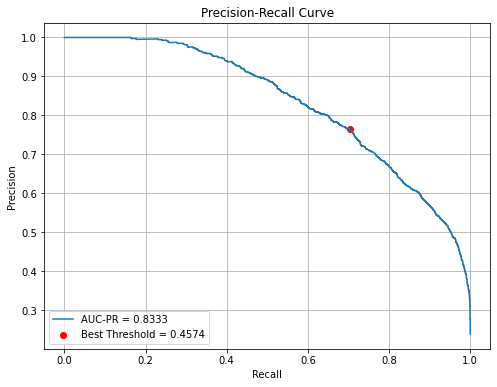


📊 Classification Report with best threshold:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      7310
           1       0.77      0.70      0.73      2295

    accuracy                           0.88      9605
   macro avg       0.84      0.82      0.83      9605
weighted avg       0.87      0.88      0.88      9605

✅ Balanced Accuracy Score: 0.8177762577899377
✔️ Accuracy: 0.87756376887038
🎯 F1 Score: 0.7329700272479565


In [5]:
# Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, gbm_probs)

# Calculate AUC-PR and Average Precision
auc_pr = auc(recall, precision)
avg_precision = average_precision_score(y_test, gbm_probs)

print("📈 AUC-PR (using auc):", auc_pr)
print("📌 Average Precision Score:", avg_precision)

# Calculate F1 scores for each threshold (length of thresholds = len(precision) - 1)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n🔥 Best Threshold = {best_threshold:.4f}")
print(f"🎯 Best F1 Score = {best_f1:.4f}")

# 4. Plot PR Curve and mark best threshold
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.4f}')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best Threshold = {best_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# 5. Apply best threshold to get predicted class labels
y_pred_best_gbm = (gbm_probs >= best_threshold).astype(int)

# 6. Print classification report using best threshold
print("\n📊 Classification Report with best threshold:\n", classification_report(y_test, y_pred_best_gbm))
print("✅ Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred_best_gbm))
print("✔️ Accuracy:", accuracy_score(y_test, y_pred_best_gbm))
print("🎯 F1 Score:", f1_score(y_test, y_pred_best_gbm))

## Adaboost

### 0.5 Threshold

In [6]:
ab_preds = adaboost.predict(X_test)
ab_probs = adaboost.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report with 0.5 threshold:\n", classification_report(y_test, ab_preds))
print("✔️ Accuracy:", accuracy_score(y_test, ab_preds))
print("✅ Balanced Accuracy Score:", balanced_accuracy_score(y_test, ab_preds))
print("🎯 F1 Score:", f1_score(y_test, ab_preds))
print("📈 AUC-PR:", average_precision_score(y_test, ab_probs))


📊 Classification Report with 0.5 threshold:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      7310
           1       0.78      0.63      0.70      2295

    accuracy                           0.87      9605
   macro avg       0.83      0.79      0.81      9605
weighted avg       0.86      0.87      0.86      9605

✔️ Accuracy: 0.8687142113482561
✅ Balanced Accuracy Score: 0.786104777828444
🎯 F1 Score: 0.6956311851315472
📈 AUC-PR: 0.8176169458773723


### Best Threshold

📈 AUC-PR (using auc): 0.8177428195779405
📌 Average Precision Score: 0.8176169458773723

🔥 Best Threshold = 0.4994
🎯 Best F1 Score = 0.7193


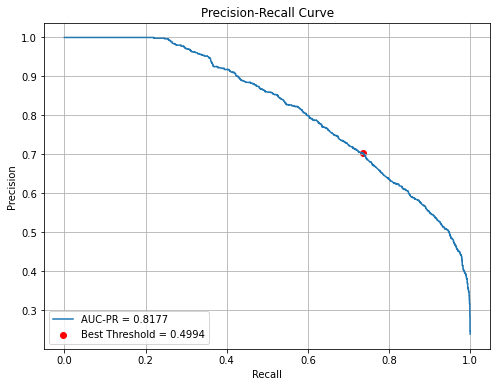


📊 Classification Report with best threshold:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      7310
           1       0.70      0.74      0.72      2295

    accuracy                           0.86      9605
   macro avg       0.81      0.82      0.81      9605
weighted avg       0.87      0.86      0.86      9605

✅ Balanced Accuracy Score: 0.8194355778487106
✔️ Accuracy: 0.8625715773034878
🎯 F1 Score: 0.7192683964270523


In [7]:
# 1. Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, ab_probs)

# 2. Calculate AUC-PR and Average Precision
auc_pr = auc(recall, precision)
avg_precision = average_precision_score(y_test, ab_probs)

print("📈 AUC-PR (using auc):", auc_pr)
print("📌 Average Precision Score:", avg_precision)

# 3. Calculate F1 scores for each threshold (length of thresholds = len(precision) - 1)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n🔥 Best Threshold = {best_threshold:.4f}")
print(f"🎯 Best F1 Score = {best_f1:.4f}")

# 4. Plot PR Curve and mark best threshold
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.4f}')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best Threshold = {best_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# 5. Apply best threshold to get predicted class labels
y_pred_best_ab = (ab_probs >= best_threshold).astype(int)

# 6. Print classification report using best threshold
print("\n📊 Classification Report with best threshold:\n", classification_report(y_test, y_pred_best_ab))
print("✅ Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred_best_ab))
print("✔️ Accuracy:", accuracy_score(y_test, y_pred_best_ab))
print("🎯 F1 Score:", f1_score(y_test, y_pred_best_ab))

## Random Forest

### 0.5 Threshold

In [8]:
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report with 0.5 threshold:\n", classification_report(y_test, rf_preds))
print("✔️ Accuracy:", accuracy_score(y_test, rf_preds))
print("✅ Balanced Accuracy Score:", balanced_accuracy_score(y_test, rf_preds))
print("🎯 F1 Score:", f1_score(y_test, rf_preds))
print("📈 AUC-PR:", average_precision_score(y_test, rf_probs))


📊 Classification Report with 0.5 threshold:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91      7310
           1       0.78      0.62      0.69      2295

    accuracy                           0.87      9605
   macro avg       0.83      0.78      0.80      9605
weighted avg       0.86      0.87      0.86      9605

✔️ Accuracy: 0.8665278500780843
✅ Balanced Accuracy Score: 0.7825758727263515
🎯 F1 Score: 0.6900386847195358
📈 AUC-PR: 0.8045256025112938


### Best Threshold

📈 AUC-PR (using auc): 0.8044932169064667
📌 Average Precision Score: 0.8045256025112938

🔥 Best Threshold = 0.4056
🎯 Best F1 Score = 0.7093


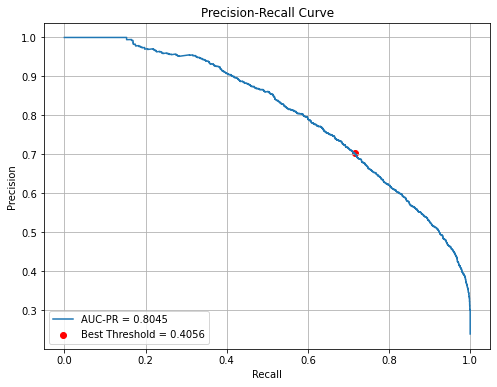


📊 Classification Report with best threshold:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      7310
           1       0.70      0.72      0.71      2295

    accuracy                           0.86      9605
   macro avg       0.81      0.81      0.81      9605
weighted avg       0.86      0.86      0.86      9605

✅ Balanced Accuracy Score: 0.8102523179814561
✔️ Accuracy: 0.859968766267569
🎯 F1 Score: 0.7093148908580074


In [9]:
# 1. Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, rf_probs)

# 2. Calculate AUC-PR and Average Precision
auc_pr = auc(recall, precision)
avg_precision = average_precision_score(y_test, rf_probs)

print("📈 AUC-PR (using auc):", auc_pr)
print("📌 Average Precision Score:", avg_precision)

# 3. Calculate F1 scores for each threshold (length of thresholds = len(precision) - 1)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n🔥 Best Threshold = {best_threshold:.4f}")
print(f"🎯 Best F1 Score = {best_f1:.4f}")

# 4. Plot PR Curve and mark best threshold
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.4f}')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best Threshold = {best_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# 5. Apply best threshold to get predicted class labels
y_pred_best_rf = (rf_probs >= best_threshold).astype(int)

# 6. Print classification report using best threshold
print("\n📊 Classification Report with best threshold:\n", classification_report(y_test, y_pred_best_rf))
print("✅ Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred_best_rf))
print("✔️ Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("🎯 F1 Score:", f1_score(y_test, y_pred_best_rf))

## ANN

### 0.5 Threshold

In [10]:
# Convert to NumPy arrays with correct dtypes for TensorFlow
X_train = X_train.to_numpy().astype(np.float32)
X_test = X_test.to_numpy().astype(np.float32)

y_train = y_train.to_numpy().astype(np.float32)  # or np.int32 depending on your model output
y_test = y_test.to_numpy().astype(np.float32)

ann_probs = ann.predict(X_test).flatten()
ann_preds = (ann_probs > 0.5).astype(int)

# 9. Print results
print("\n📊 Classification Report with 0.5 threshold:\n", classification_report(y_test, ann_preds, target_names=label_enc.classes_))
print("✔️ Accuracy:", accuracy_score(y_test, ann_preds))
print("✅ Balanced Accuracy Score:", balanced_accuracy_score(y_test, ann_preds))
print("🎯 F1 Score:", f1_score(y_test, ann_preds))
print("📈 AUC-PR:", average_precision_score(y_test, ann_probs))

301/301 [==============================] - 0s 586us/step

📊 Classification Report with 0.5 threshold:
               precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      7310
        >50K       0.74      0.64      0.68      2295

    accuracy                           0.86      9605
   macro avg       0.81      0.78      0.80      9605
weighted avg       0.85      0.86      0.86      9605

✔️ Accuracy: 0.8589276418532015
✅ Balanced Accuracy Score: 0.7834118660384051
🎯 F1 Score: 0.6839281548868673
📈 AUC-PR: 0.7796532034101312


### Best Threshold

📈 AUC-PR (using auc): 0.7796006603164347
📌 Average Precision Score: 0.7796532034101312

🔥 Best Threshold = 0.3835
🎯 Best F1 Score = 0.7034


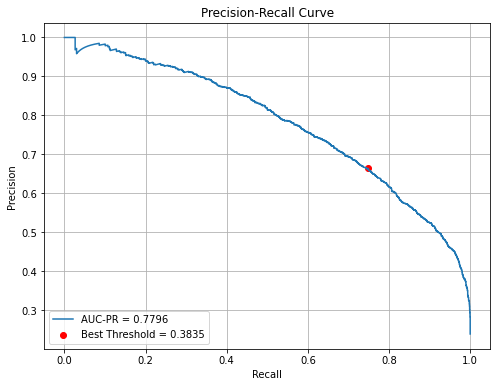


📊 Classification Report with best threshold:
               precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      7310
         1.0       0.66      0.75      0.70      2295

    accuracy                           0.85      9605
   macro avg       0.79      0.81      0.80      9605
weighted avg       0.86      0.85      0.85      9605

✅ Balanced Accuracy Score: 0.8145665501342656
✔️ Accuracy: 0.8492451847995836
🎯 F1 Score: 0.7034002458009013


In [11]:
# 1. Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, ann_probs)

# 2. Calculate AUC-PR and Average Precision
auc_pr = auc(recall, precision)
avg_precision = average_precision_score(y_test, ann_probs)

print("📈 AUC-PR (using auc):", auc_pr)
print("📌 Average Precision Score:", avg_precision)

# 3. Calculate F1 scores for each threshold (length of thresholds = len(precision) - 1)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n🔥 Best Threshold = {best_threshold:.4f}")
print(f"🎯 Best F1 Score = {best_f1:.4f}")

# 4. Plot PR Curve and mark best threshold
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.4f}')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best Threshold = {best_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# 5. Apply best threshold to get predicted class labels
y_pred_best_ann = (ann_probs >= best_threshold).astype(int)

# 6. Print classification report using best threshold
print("\n📊 Classification Report with best threshold:\n", classification_report(y_test, y_pred_best_ann))
print("✅ Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred_best_ann))
print("✔️ Accuracy:", accuracy_score(y_test, y_pred_best_ann))
print("🎯 F1 Score:", f1_score(y_test, y_pred_best_ann))

## Evaluation Table for 0.5 Threshold

In [12]:
# Dictionary to collect all results
metrics_summary = {
    "Model": [],
    "Accuracy": [],
    "Balanced Accuracy": [],
    "F1 Score": [],
    "AUC-PR": []
}

# Add metrics for each model
models = {
    "GBM": (gbm_preds, gbm_probs),
    "AdaBoost": (ab_preds, ab_probs),
    "Random Forest": (rf_preds, rf_probs),
    "ANN": (ann_preds, ann_probs)
}

for model_name, (preds, probs) in models.items():
    metrics_summary["Model"].append(model_name)
    metrics_summary["Accuracy"].append(accuracy_score(y_test, preds))
    metrics_summary["Balanced Accuracy"].append(balanced_accuracy_score(y_test, preds))
    metrics_summary["F1 Score"].append(f1_score(y_test, preds))
    metrics_summary["AUC-PR"].append(average_precision_score(y_test, probs))

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_summary)

# Display the summary
print("\n📋 Model Evaluation Summary for 0.5 threshold:\n")
metrics_df.round(4)



📋 Model Evaluation Summary for 0.5 threshold:



,Model,Accuracy,Balanced Accuracy,F1 Score,AUC-PR
0,GBM,0.8757,0.8028,0.7183,0.8333
1,AdaBoost,0.8687,0.7861,0.6956,0.8176
2,Random Forest,0.8665,0.7826,0.6900,0.8045
3,ANN,0.8589,0.7834,0.6839,0.7797


## Evaluation Table for Best Thresholds

In [13]:
# Dictionary to collect all results
metrics_summary = {
    "Model": [],
    "Accuracy": [],
    "Balanced Accuracy": [],
    "F1 Score": [],
    "AUC-PR": []
}

# Add metrics for each model
models = {
    "GBM": (y_pred_best_gbm, gbm_probs),
    "AdaBoost": (y_pred_best_ab, ab_probs),
    "Random Forest": (y_pred_best_rf, rf_probs),
    "ANN": (y_pred_best_ann, ann_probs)
}

for model_name, (preds, probs) in models.items():
    metrics_summary["Model"].append(model_name)
    metrics_summary["Accuracy"].append(accuracy_score(y_test, preds))
    metrics_summary["Balanced Accuracy"].append(balanced_accuracy_score(y_test, preds))
    metrics_summary["F1 Score"].append(f1_score(y_test, preds))
    metrics_summary["AUC-PR"].append(average_precision_score(y_test, probs))

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_summary)

# Display the summary
print("\n📋 Model Evaluation Summary for best threshold:\n")
metrics_df.round(4)


📋 Model Evaluation Summary for best threshold:



,Model,Accuracy,Balanced Accuracy,F1 Score,AUC-PR
0,GBM,0.8776,0.8178,0.7330,0.8333
1,AdaBoost,0.8626,0.8194,0.7193,0.8176
2,Random Forest,0.8600,0.8103,0.7093,0.8045
3,ANN,0.8492,0.8146,0.7034,0.7797


## Model Evaluation and Best Model Selection

### 1. Evaluation Using Default 0.5 Threshold

Initially, I evaluated all models using the default threshold value of **0.5**, which is commonly used in binary classification tasks.  
For each model, I calculated **Accuracy**, **Balanced Accuracy**, **F1 Score**, and **AUC-PR**.

As shown in the table below, **GBM** achieved the highest Accuracy at **87.57%** and also led with an **F1 Score of 0.7183**.  
On the other hand, **ANN** showed the lowest performance across most of the metrics.

However, this evaluation is based on a default threshold, and considering our dataset is imbalanced, this might not provide the most reliable insight — especially for the minority class ('>50K').

| Model          | Accuracy | Balanced Accuracy | F1 Score | AUC-PR |
|----------------|----------|--------------------|----------|--------|
| GBM            | 0.8757   | 0.8028              | 0.7183   | 0.8333 |
| AdaBoost       | 0.8687   | 0.7861              | 0.6956   | 0.8176 |
| Random Forest  | 0.8665   | 0.7826              | 0.6900   | 0.8045 |
| ANN            | 0.8589   | 0.7834              | 0.6839   | 0.7797 |

---

### 2. Threshold Optimization Using AUC-PR Curve

Since the dataset is imbalanced — with fewer samples belonging to the '**>50K**' class — using a fixed 0.5 threshold may not yield the best results, particularly for the minority class.

To address this, I optimized the decision threshold for each model individually.  
I used the **Precision-Recall (AUC-PR) curve** to find the threshold that gives the **highest F1 Score**.

After re-evaluating the models with the optimized thresholds, **GBM** again delivered the best performance, now with an even higher **F1 Score of 0.7330** and **Accuracy of 87.76%**.  
Other models like **AdaBoost** and **Random Forest** also showed slight improvements but still couldn’t match GBM’s performance.

| Model          | Accuracy | Balanced Accuracy | F1 Score | AUC-PR |
|----------------|----------|--------------------|----------|--------|
| GBM            | 0.8776   | 0.8178              | 0.7330   | 0.8333 |
| AdaBoost       | 0.8626   | 0.8194              | 0.7193   | 0.8176 |
| Random Forest  | 0.8600   | 0.8103              | 0.7093   | 0.8045 |
| ANN            | 0.8492   | 0.8146              | 0.7034   | 0.7797 |

---

### 3. Model Selection Criteria and Final Decision

When selecting the best model, I focused mainly on two metrics:

- **Accuracy**: Reflects how well the model performs across both classes.
- **F1 Score**: Focuses on the model's ability to correctly predict the minority class (`>50K`).

While all models showed improvements after threshold optimization, **GBM consistently outperformed the others** in both Accuracy and F1 Score.

**Therefore, based on the evaluation results, I selected the Gradient Boosting Machine (GBM) as the best-performing model for this task.**

